In [ ]:
! pip install twarc
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install scikit-learn

In [2]:
import pandas as pd
from twarc import Twarc2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import math
import scipy.stats as stats

## Data retrieval

In [35]:
#accessing API

bearer_token = "AAAAAAAAAAAAAAAAAAAAAD8mjwEAAAAAFK99OuhAbSD0Mq8xToy%2FBRMubvI%3DUb1TLMJzLAxuYBfCqPbOMjUNjL1VcVXdEEsjNuOD9i0070DOdH" 
twarc_client = Twarc2(bearer_token=bearer_token)

In [30]:
#creating an initial dataframe of US political journalists/pundits using a Twitter list

pundits = []
for pundit in twarc_client.list_members(list_id = 15084461): 
    for p_dict in pundit['data']:
        pundits.append(p_dict)         
pundits = pd.json_normalize(pundits)

#removing protected and less popular accounts from the list
pundits = pundits[(pundits['protected']==False)&(pundits['public_metrics.followers_count']>10000)&(pundits['public_metrics.tweet_count']>1000)] 
display(pundits)

,username,description,id,name,protected,created_at,verified,profile_image_url,public_metrics.followers_count,public_metrics.following_count,public_metrics.tweet_count,public_metrics.listed_count,location,url,entities.url.urls,entities.description.urls,entities.description.mentions,pinned_tweet_id,entities.description.hashtags
1,pkcapitol,"Washington Post congressional reporter, devote...",997684836,Paul Kane,False,2012-12-08T18:16:23.000Z,True,https://pbs.twimg.com/profile_images/150503170...,89861,318,36140,2183,"Capitol Hill, DC",https://t.co/Mvmf9pAgjq,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,NaN
2,robyoon,"journalism, politics, higher ed, oh my",620618811,Robert Yoon,False,2012-06-28T02:03:06.000Z,True,https://pbs.twimg.com/profile_images/161072146...,11904,1282,4620,323,NaN,https://t.co/vpn5NRgMnF,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,NaN
5,AP_Politics,Highlights from AP's coverage of U.S. politics...,426802833,AP Politics,False,2011-12-02T18:26:10.000Z,True,https://pbs.twimg.com/profile_images/184826268...,554143,600,86291,7886,"Washington, D.C.",https://t.co/oS489jIdWx,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...","[{'start': 124, 'end': 147, 'url': 'https://t....",NaN,NaN,NaN
6,burgessev,POLITICO congressional bureau chief. Photo by ...,407013776,Burgess Everett,False,2011-11-07T14:22:19.000Z,True,https://pbs.twimg.com/profile_images/139827819...,139442,2421,51488,2813,A hallway in the Capitol.,https://t.co/8vqs94MMLn,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,"[{'start': 46, 'end': 57, 'username': 'frankth...",NaN,NaN
7,MEPFuller,Washington Bureau Chief for The Daily Beast. W...,398088661,Matt Fuller,False,2011-10-25T15:20:25.000Z,True,https://pbs.twimg.com/profile_images/137221221...,246315,4354,71859,3499,"Washington, D.C.",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,ethanklapper,@AmericanAir comms. Former journalist. Thought...,6332292,Ethan Klapper,False,2007-05-26T03:18:34.000Z,True,https://pbs.twimg.com/profile_images/124402957...,23875,5795,13914,1132,Texas,NaN,NaN,NaN,"[{'start': 0, 'end': 12, 'username': 'American...",1611037177349132291,NaN
399,PeterHamby,Host @Snapchat's @GoodLuckAmerica. Partner @Pu...,5336752,Peter Hamby,False,2007-04-20T15:53:03.000Z,True,https://pbs.twimg.com/profile_images/135814116...,100832,9052,30406,2571,"Los Angeles, CA",NaN,NaN,"[{'start': 139, 'end': 162, 'url': 'https://t....","[{'start': 5, 'end': 14, 'username': 'Snapchat...",1539770316536176640,NaN
400,palafo,"Editor of Express breaking/trending news team,...",2020351,Patrick LaForge,False,2007-03-23T15:13:43.000Z,True,https://pbs.twimg.com/profile_images/158891229...,35892,3393,18752,2168,Here,https://t.co/bgr53gX6HS,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...","[{'start': 63, 'end': 86, 'url': 'https://t.co...","[{'start': 47, 'end': 55, 'username': 'nytimes'}]",NaN,NaN
401,Shawna,"@CBSMornings' ""big cheese boss"" Formerly of Qu...",1025521,Shawna Thomas,False,2007-03-12T16:57:58.000Z,True,https://pbs.twimg.com/profile_images/103092485...,39144,10795,41729,885,New York City,https://t.co/XdReTSrxPD,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,"[{'start': 0, 'end': 12, 'username': 'CBSMorni...",1188292066075402240,NaN


In [ ]:
#getting the latest tweet from each pundit
pundits = pd.read_csv('pundits.csv')
pundit_latest = []
for pundit in pundits.id.values:
    data = twarc_client.timeline(pundit, max_results=1) 
    pundit_latest.append(next(data)['data'][0])
pundit_latest = pd.json_normalize(pundit_latest)
display(pundit_latest)

In [7]:
latest_tweets=pundit_latest[['author_id','created_at']]
display(latest_tweets)

,author_id,created_at
0,997684836,2023-03-15T18:07:45.000Z
1,620618811,2022-11-13T03:17:55.000Z
2,426802833,2023-03-16T10:48:07.000Z
3,407013776,2023-03-15T18:55:37.000Z
4,398088661,2023-03-15T00:15:55.000Z
...,...,...
268,6332292,2023-03-05T15:21:19.000Z
269,5336752,2023-03-16T02:36:55.000Z
270,2020351,2023-03-16T02:47:13.000Z
271,1025521,2023-03-13T01:56:25.000Z


In [ ]:
latest_tweets['author_id']=latest_tweets['author_id'].astype(int)

In [12]:
#adding latest tweet data to the main pundits dataframe
pundits = pundits.merge(latest_tweets,left_on='id',right_on='author_id')

In [14]:
#removing pundits who have not tweeted since 01.02.
pundits = pundits[(pundits['created_at_y']>'2023-02-01')]
display(pundits)
pundits.to_csv('pundits1.csv',index=False)

,verified,profile_image_url,protected,created_at_x,name,id,description,username,public_metrics.followers_count,public_metrics.following_count,...,public_metrics.listed_count,url,location,entities.url.urls,entities.description.urls,entities.description.mentions,pinned_tweet_id,entities.description.hashtags,author_id,created_at_y
0,True,https://pbs.twimg.com/profile_images/150503170...,False,2012-12-08T18:16:23.000Z,Paul Kane,997684836,"Washington Post congressional reporter, devote...",pkcapitol,89880,318,...,2183,https://t.co/Mvmf9pAgjq,"Capitol Hill, DC","[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,NaN,997684836,2023-03-15T18:07:45.000Z
2,True,https://pbs.twimg.com/profile_images/184826268...,False,2011-12-02T18:26:10.000Z,AP Politics,426802833,Highlights from AP's coverage of U.S. politics...,AP_Politics,554239,600,...,7889,https://t.co/oS489jIdWx,"Washington, D.C.","[{'start': 0, 'end': 23, 'url': 'https://t.co/...","[{'start': 124, 'end': 147, 'url': 'https://t....",NaN,NaN,NaN,426802833,2023-03-16T10:48:07.000Z
3,True,https://pbs.twimg.com/profile_images/139827819...,False,2011-11-07T14:22:19.000Z,Burgess Everett,407013776,POLITICO congressional bureau chief. Photo by ...,burgessev,139433,2422,...,2812,https://t.co/8vqs94MMLn,A hallway in the Capitol.,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,"[{'start': 46, 'end': 57, 'username': 'frankth...",NaN,NaN,407013776,2023-03-15T18:55:37.000Z
4,True,https://pbs.twimg.com/profile_images/137221221...,False,2011-10-25T15:20:25.000Z,Matt Fuller,398088661,Washington Bureau Chief for The Daily Beast. W...,MEPFuller,246354,4355,...,3500,NaN,"Washington, D.C.",NaN,NaN,NaN,NaN,NaN,398088661,2023-03-15T00:15:55.000Z
5,True,https://pbs.twimg.com/profile_images/123021369...,False,2011-09-15T05:49:21.000Z,jack healy,373791638,"Once in Baghdad, now Rocky Mountain correspond...",jackhealyNYT,16647,3928,...,520,https://t.co/zGJ4T9a0YP,NaN,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,1.607911e+18,NaN,373791638,2023-03-08T16:05:01.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,True,https://pbs.twimg.com/profile_images/124402957...,False,2007-05-26T03:18:34.000Z,Ethan Klapper,6332292,@AmericanAir comms. Former journalist. Thought...,ethanklapper,23879,5796,...,1132,NaN,Texas,NaN,NaN,"[{'start': 0, 'end': 12, 'username': 'American...",1.611037e+18,NaN,6332292,2023-03-05T15:21:19.000Z
269,True,https://pbs.twimg.com/profile_images/135814116...,False,2007-04-20T15:53:03.000Z,Peter Hamby,5336752,Host @Snapchat's @GoodLuckAmerica. Partner @Pu...,PeterHamby,100842,9046,...,2571,NaN,"Los Angeles, CA",NaN,"[{'start': 139, 'end': 162, 'url': 'https://t....","[{'start': 5, 'end': 14, 'username': 'Snapchat...",1.539770e+18,NaN,5336752,2023-03-16T02:36:55.000Z
270,True,https://pbs.twimg.com/profile_images/158891229...,False,2007-03-23T15:13:43.000Z,Patrick LaForge,2020351,"Editor of Express breaking/trending news team,...",palafo,35900,3392,...,2170,https://t.co/bgr53gX6HS,Here,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...","[{'start': 63, 'end': 86, 'url': 'https://t.co...","[{'start': 47, 'end': 55, 'username': 'nytimes'}]",NaN,NaN,2020351,2023-03-16T02:47:13.000Z
271,True,https://pbs.twimg.com/profile_images/103092485...,False,2007-03-12T16:57:58.000Z,Shawna Thomas,1025521,"@CBSMornings' ""big cheese boss"" Formerly of Qu...",Shawna,39143,10798,...,885,https://t.co/XdReTSrxPD,New York City,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,"[{'start': 0, 'end': 12, 'username': 'CBSMorni...",1.188292e+18,NaN,1025521,2023-03-13T01:56:25.000Z


In [ ]:
#for all remaining 253 pundits, get their timelines (max. 300 tweets for each)

pundit_timelines = []
for pundit in pundits.id.values:
    data = twarc_client.timeline(pundit, max_results=100) 
    pundit_timelines.append(next(data)['data'])
    pundit_timelines.append(next(data)['data'])
    pundit_timelines.append(next(data)['data'])
pundit_timelines = pd.json_normalize(pundit_timelines)
display(pundit_timelines)

In [77]:
pundit_timelines.to_csv('timelines.csv',index=False)


In [33]:
#reshaping the pundit timelines dataframe into a single column
pt_new = pd.read_csv('timelines.csv').stack().reset_index()

#functions to extract tweet texts, dates, authors and their follower numbers 

def extract_text(x):
    return eval(x)['text']
def extract_date(x):
    return eval(x)['created_at']
def extract_author(x):
    return eval(x)['author_id']
def find_followers(x):
    return pundits[pundits.id==x]['public_metrics.followers_count'].iloc[0]

In [ ]:
#creating new columns for texts, dates, authors and their follower numbers

pt_new.columns = ['level_0','level_1','raw']
pt_new['tweet'] = pt_new['raw'].apply(extract_text)
pt_new['date'] = pt_new['raw'].apply(extract_date)
pt_new['author'] = pt_new['raw'].apply(extract_author)
pt_new['followers'] = pt_new['author'].apply(find_followers)

In [55]:
pt_new = pt_new.sort_values(by=['date'])

In [57]:
pt_new[['raw','tweet','date','author','followers']].to_csv('pt.csv',index=False)

## Data Analysis

In [ ]:
# getting 2022 data

pt_new['date'] = pd.to_datetime(pt_new['date'])

pt_new = pt_new[(pt_new['date'].dt.year == 2022)]
pt_new.index = np.arange(0, len(pt_new))
pt_new

In [ ]:
#finding tweets mentioning inflation/prices/gas

pt_new["contains_inflation"] = pt_new["tweet"].str.contains(r'\b(inflation|prices|gas)\b')

In [63]:
#segregate inflation, non inflation data into separate dataframes

pt_non_inflation = pt_new[pt_new['contains_inflation'] == False]
pt_non_inflation.index = np.arange(0, len(pt_non_inflation))

pt_inflation = pt_new[pt_new['contains_inflation'] == True]
pt_inflation.index = np.arange(0, len(pt_inflation))

pt_inflation

,level_0,level_1,raw,tweet,date,author,followers,contains_inflation
0,295,16,"{'lang': 'en', 'author_id': '59676104', 'conte...",Democrats worry Biden could pay the political ...,2022-01-13 02:03:14+00:00,59676104,114523,True
1,566,53,{'edit_history_tweet_ids': ['14907978468614266...,@TheStalwart @DanSichel1 surprised home prices...,2022-02-07 21:21:19+00:00,17044233,51439,True
2,451,17,"{'id': '1494283174574280712', 'reply_settings'...",White House planning to recast Biden’s economi...,2022-02-17 12:10:45+00:00,22772264,72817,True
3,254,35,"{'lang': 'en', 'id': '1496924514306838542', 'c...",Why is Putin doing this? What comes next and h...,2022-02-24 19:06:30+00:00,80638910,111424,True
4,254,25,"{'in_reply_to_user_id': '80638910', 'lang': 'e...",Barring Russia from SWIFT would have far-reach...,2022-02-25 01:53:35+00:00,80638910,111424,True
...,...,...,...,...,...,...,...,...
208,38,26,"{'id': '1608096935709396993', 'reply_settings'...",RT @OrinKerr: How bad is grade inflation at Ha...,2022-12-28 13:46:01+00:00,282545479,286015,True
209,138,87,"{'lang': 'en', 'author_id': '147649517', 'cont...","Important reminder here, via ever-helpful @ela...",2022-12-29 18:41:48+00:00,147649517,65256,True
210,368,66,"{'referenced_tweets': [{'type': 'replied_to', ...",@the_vello I rented a car at Detroit airport C...,2022-12-29 21:43:17+00:00,43409523,68080,True
211,727,87,"{'lang': 'en', 'text': 'Median home prices by ...",Median home prices by state: Highest in Hawaii...,2022-12-30 17:26:30+00:00,12272322,59539,True


In [64]:
pt_inflation.to_csv('inflation.csv',index=False)

In [ ]:
# using VADER for sentiment analysis for non inflation data

vader = SentimentIntensityAnalyzer()

pt_non_inflation["VADER_compound"] = 0.0
for i in range(len(pt_non_inflation['tweet'])):
    print(i, end="\r")
    sentiment_dict_non_inflation = vader.polarity_scores(pt_non_inflation['tweet'][i])
    pt_non_inflation["VADER_compound"][i] = float(sentiment_dict_non_inflation['compound'])
    
# iterate over dataframe rows and assign sentiment to each row

pt_non_inflation['VADER_class'] = pt_non_inflation['VADER_compound'].apply(lambda x: "Positive" if x > 0.3 else "Negative" if x < -0.3 else "Neutral")


In [68]:
pt_non_inflation

,level_0,level_1,raw,tweet,date,author,followers,contains_inflation,VADER_compound,VADER_class
0,236,23,"{'id': '1477071586205347842', 'reply_settings'...",@tomscocca The best bag though. Swear by it.,2022-01-01 00:18:03+00:00,87584353,23763,False,0.6124,Positive
1,236,22,"{'id': '1477076285520236548', 'reply_settings'...",@tomscocca Scissors?,2022-01-01 00:36:43+00:00,87584353,23763,False,0.0000,Neutral
2,236,21,"{'id': '1477097001527517185', 'reply_settings'...",RIP. https://t.co/7XHRiyQXyU,2022-01-01 01:59:02+00:00,87584353,23763,False,0.0000,Neutral
3,534,65,{'edit_history_tweet_ids': ['14771420402866790...,"RT @KyleClark: Last night, you watched as hund...",2022-01-01 04:58:01+00:00,18637396,90314,False,-0.3182,Negative
4,217,72,"{'lang': 'en', 'id': '1477144594760491016', 'c...",Happy New Years everyone and how is “this is w...,2022-01-01 05:08:10+00:00,102238997,24864,False,0.9202,Positive
...,...,...,...,...,...,...,...,...,...,...
30028,355,55,"{'id': '1609334974460616707', 'reply_settings'...",WOW….Michigan digs a deep hole…TCU 34 …Michiga...,2022-12-31 23:45:32+00:00,46479416,158921,False,0.0000,Neutral
30029,226,66,"{'possibly_sensitive': False, 'text': 'I apolo...",I apologize for underestimating TCU all season.,2022-12-31 23:47:11+00:00,93876666,51141,False,0.1027,Neutral
30030,355,54,"{'id': '1609335478548893702', 'reply_settings'...",There are Apple Turnovers…Cherry Turnovers … a...,2022-12-31 23:47:32+00:00,46479416,158921,False,0.0000,Neutral
30031,368,56,"{'referenced_tweets': [{'type': 'retweeted', '...",RT @symonemsnbc: .@JonAllenDC addresses the IR...,2022-12-31 23:52:43+00:00,43409523,68080,False,-0.3182,Negative


In [ ]:
# using VADER for sentiment analysis for inflation data

vader = SentimentIntensityAnalyzer()

pt_inflation["VADER_compound"] = 0.0
for i in range(len(pt_inflation['tweet'])):
    print(i, end="\r")
    sentiment_dict_inflation = vader.polarity_scores(pt_inflation['tweet'][i]) 
    pt_inflation["VADER_compound"][i] = float(sentiment_dict_inflation['compound'])
    
# iterate over dataframe rows and assign sentiment to each row

pt_inflation['VADER_class'] = pt_inflation['VADER_compound'].apply(lambda x: "Positive" if x > 0.3 else "Negative" if x < -0.3 else "Neutral")

In [70]:
pt_inflation

,level_0,level_1,raw,tweet,date,author,followers,contains_inflation,VADER_compound,VADER_class
0,295,16,"{'lang': 'en', 'author_id': '59676104', 'conte...",Democrats worry Biden could pay the political ...,2022-01-13 02:03:14+00:00,59676104,114523,True,-0.5106,Negative
1,566,53,{'edit_history_tweet_ids': ['14907978468614266...,@TheStalwart @DanSichel1 surprised home prices...,2022-02-07 21:21:19+00:00,17044233,51439,True,0.2263,Neutral
2,451,17,"{'id': '1494283174574280712', 'reply_settings'...",White House planning to recast Biden’s economi...,2022-02-17 12:10:45+00:00,22772264,72817,True,-0.3612,Negative
3,254,35,"{'lang': 'en', 'id': '1496924514306838542', 'c...",Why is Putin doing this? What comes next and h...,2022-02-24 19:06:30+00:00,80638910,111424,True,0.6671,Positive
4,254,25,"{'in_reply_to_user_id': '80638910', 'lang': 'e...",Barring Russia from SWIFT would have far-reach...,2022-02-25 01:53:35+00:00,80638910,111424,True,0.2593,Neutral
...,...,...,...,...,...,...,...,...,...,...
208,38,26,"{'id': '1608096935709396993', 'reply_settings'...",RT @OrinKerr: How bad is grade inflation at Ha...,2022-12-28 13:46:01+00:00,282545479,286015,True,0.0516,Neutral
209,138,87,"{'lang': 'en', 'author_id': '147649517', 'cont...","Important reminder here, via ever-helpful @ela...",2022-12-29 18:41:48+00:00,147649517,65256,True,0.1476,Neutral
210,368,66,"{'referenced_tweets': [{'type': 'replied_to', ...",@the_vello I rented a car at Detroit airport C...,2022-12-29 21:43:17+00:00,43409523,68080,True,0.0000,Neutral
211,727,87,"{'lang': 'en', 'text': 'Median home prices by ...",Median home prices by state: Highest in Hawaii...,2022-12-30 17:26:30+00:00,12272322,59539,True,-0.3818,Negative


In [71]:
#average sentiment figures for non-inflation, inflation and #inflation tweets
rows = ['Positive', 'Negative', 'Neutral']
columns = ['Non Inflation', 'Inflation']

result = pd.DataFrame(columns = columns, index = rows)

def avg_data(data):
    N = len(data)
    p_count = 0
    neu_count = 0
    n_count = 0
    for i in range(len(data)):
        if data['VADER_class'][i] == 'Positive':
            p_count += 1
        elif data['VADER_class'][i] == 'Negative':
            n_count += 1
        else:
            neu_count += 1

    p_result = p_count/N
    n_result = n_count/N
    neu_result = neu_count/N
    
    return p_result, n_result, neu_result
    
p_inflation,n_inflation,neu_inflation = avg_data(pt_inflation)
result['Inflation'] = p_inflation, n_inflation, neu_inflation

p_non, n_non, neu_non = avg_data(pt_non_inflation)
result['Non Inflation'] = p_non, n_non, neu_non

result

,Non Inflation,Inflation
Positive,0.349549,0.300469
Negative,0.184530,0.239437
Neutral,0.465921,0.460094


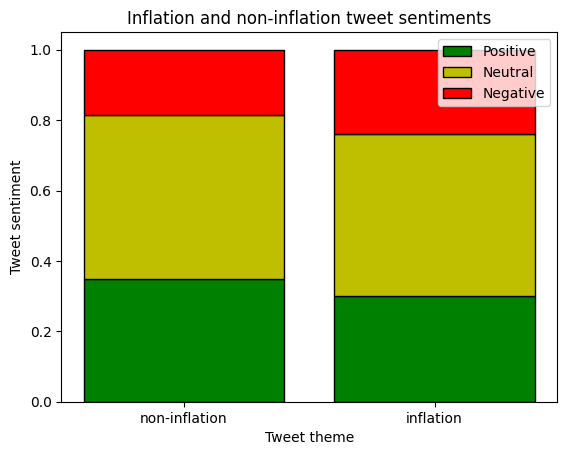

In [72]:
#creating a bar plot showing connections between inflation theme and sentiments

x = ["non-inflation", "inflation"]
y_positive = np.array(result.iloc[0])
y_neutral = np.array(result.iloc[2])
y_negative = np.array(result.iloc[1])
 
# plot stack bars
plt.bar(x, y_positive, color="g", edgecolor = "k")
plt.bar(x, y_neutral, bottom=y_positive, color='y', edgecolor = "k")
plt.bar(x, y_negative, bottom=y_positive+y_neutral, color='r', edgecolor = "k")
plt.xlabel("Tweet theme")
plt.ylabel("Tweet sentiment")
plt.legend(["Positive", "Neutral", "Negative"])
plt.title("Inflation and non-inflation tweet sentiments")
plt.show()

In [73]:
#finding an observed values matrix for a chi-square test

obs = np.array([y_positive, y_neutral, y_negative])
display (obs)

array([[0.34954883, 0.30046948],
       [0.46592082, 0.4600939 ],
       [0.18453035, 0.23943662]])

In [74]:
#chi-square test results. Actual test value is 0.013 with p = 0.994 and 2 degrees of freedom 

stats.chi2_contingency(obs)[0:4]


(0.010853071957530378,
 0.9945881610708921,
 2,
 array([[0.32500916, 0.32500916],
        [0.46300736, 0.46300736],
        [0.21198348, 0.21198348]]))

In [75]:
#parameters for a chi-square chart

crit = stats.chi2.ppf(0.95,2)
x_scale = np.linspace(0,stats.chi2.ppf(0.95,2),100)
display(x_scale)

array([0.        , 0.06051984, 0.12103969, 0.18155953, 0.24207938,
       0.30259922, 0.36311906, 0.42363891, 0.48415875, 0.5446786 ,
       0.60519844, 0.66571828, 0.72623813, 0.78675797, 0.84727781,
       0.90779766, 0.9683175 , 1.02883735, 1.08935719, 1.14987703,
       1.21039688, 1.27091672, 1.33143657, 1.39195641, 1.45247625,
       1.5129961 , 1.57351594, 1.63403579, 1.69455563, 1.75507547,
       1.81559532, 1.87611516, 1.93663501, 1.99715485, 2.05767469,
       2.11819454, 2.17871438, 2.23923422, 2.29975407, 2.36027391,
       2.42079376, 2.4813136 , 2.54183344, 2.60235329, 2.66287313,
       2.72339298, 2.78391282, 2.84443266, 2.90495251, 2.96547235,
       3.0259922 , 3.08651204, 3.14703188, 3.20755173, 3.26807157,
       3.32859142, 3.38911126, 3.4496311 , 3.51015095, 3.57067079,
       3.63119063, 3.69171048, 3.75223032, 3.81275017, 3.87327001,
       3.93378985, 3.9943097 , 4.05482954, 4.11534939, 4.17586923,
       4.23638907, 4.29690892, 4.35742876, 4.41794861, 4.47846

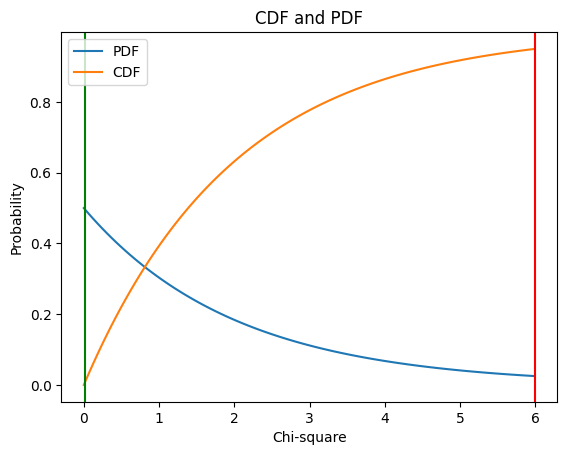

In [76]:
#plotting a chart with cumulative distribution and probability density functions

plt.title("CDF and PDF")
plt.plot(x_scale,stats.chi2.pdf(x_scale,2),label="PDF")
plt.plot(x_scale,stats.chi2.cdf(x_scale,2),label="СDF")
plt.axvline(crit,color="r")
plt.axvline(stats.chi2_contingency(obs)[0],color="g")
plt.xlabel("Chi-square")
plt.ylabel("Probability")
plt.legend(loc="upper left")
plt.show()

#critical value is marked by a red line, actual value - by a green line

In [ ]:
#calculating an impact (sum of retweets and quotes, divided by a number of followers) for each tweet

pt_new["impact"] = 0
for i in range(len(pt_new['raw'])):
    pt_new["impact"][i] = (eval(pt_new["raw"][i])["public_metrics.retweet_count"]+eval(pt_new["raw"][i])["public_metrics.quote_count"])/pt_new["followers"][i]

In [86]:
pt_new

,level_0,level_1,raw,tweet,date,author,followers,contains_inflation,impact
0,236,23,"{'id': '1477071586205347842', 'reply_settings'...",@tomscocca The best bag though. Swear by it.,2022-01-01 00:18:03+00:00,87584353,23763,False,0.000000
1,236,22,"{'id': '1477076285520236548', 'reply_settings'...",@tomscocca Scissors?,2022-01-01 00:36:43+00:00,87584353,23763,False,0.000000
2,236,21,"{'id': '1477097001527517185', 'reply_settings'...",RIP. https://t.co/7XHRiyQXyU,2022-01-01 01:59:02+00:00,87584353,23763,False,0.000000
3,534,65,{'edit_history_tweet_ids': ['14771420402866790...,"RT @KyleClark: Last night, you watched as hund...",2022-01-01 04:58:01+00:00,18637396,90314,False,0.004783
4,217,72,"{'lang': 'en', 'id': '1477144594760491016', 'c...",Happy New Years everyone and how is “this is w...,2022-01-01 05:08:10+00:00,102238997,24864,False,0.000000
...,...,...,...,...,...,...,...,...,...
30241,355,55,"{'id': '1609334974460616707', 'reply_settings'...",WOW….Michigan digs a deep hole…TCU 34 …Michiga...,2022-12-31 23:45:32+00:00,46479416,158921,False,0.000019
30242,226,66,"{'possibly_sensitive': False, 'text': 'I apolo...",I apologize for underestimating TCU all season.,2022-12-31 23:47:11+00:00,93876666,51141,False,0.000020
30243,355,54,"{'id': '1609335478548893702', 'reply_settings'...",There are Apple Turnovers…Cherry Turnovers … a...,2022-12-31 23:47:32+00:00,46479416,158921,False,0.000082
30244,368,56,"{'referenced_tweets': [{'type': 'retweeted', '...",RT @symonemsnbc: .@JonAllenDC addresses the IR...,2022-12-31 23:52:43+00:00,43409523,68080,False,0.000191


In [ ]:
pt_inflation["impact"] = 0
for i in range(len(pt_inflation['raw'])):
    pt_inflation["impact"][i] = (eval(pt_inflation["raw"][i])["public_metrics.retweet_count"]+eval(pt_inflation["raw"][i])["public_metrics.quote_count"])/pt_inflation["followers"][i]

In [89]:
pt_inflation

,level_0,level_1,raw,tweet,date,author,followers,contains_inflation,VADER_compound,VADER_class,impact
0,295,16,"{'lang': 'en', 'author_id': '59676104', 'conte...",Democrats worry Biden could pay the political ...,2022-01-13 02:03:14+00:00,59676104,114523,True,-0.5106,Negative,0.000044
1,566,53,{'edit_history_tweet_ids': ['14907978468614266...,@TheStalwart @DanSichel1 surprised home prices...,2022-02-07 21:21:19+00:00,17044233,51439,True,0.2263,Neutral,0.000000
2,451,17,"{'id': '1494283174574280712', 'reply_settings'...",White House planning to recast Biden’s economi...,2022-02-17 12:10:45+00:00,22772264,72817,True,-0.3612,Negative,0.000082
3,254,35,"{'lang': 'en', 'id': '1496924514306838542', 'c...",Why is Putin doing this? What comes next and h...,2022-02-24 19:06:30+00:00,80638910,111424,True,0.6671,Positive,0.000000
4,254,25,"{'in_reply_to_user_id': '80638910', 'lang': 'e...",Barring Russia from SWIFT would have far-reach...,2022-02-25 01:53:35+00:00,80638910,111424,True,0.2593,Neutral,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
208,38,26,"{'id': '1608096935709396993', 'reply_settings'...",RT @OrinKerr: How bad is grade inflation at Ha...,2022-12-28 13:46:01+00:00,282545479,286015,True,0.0516,Neutral,0.003545
209,138,87,"{'lang': 'en', 'author_id': '147649517', 'cont...","Important reminder here, via ever-helpful @ela...",2022-12-29 18:41:48+00:00,147649517,65256,True,0.1476,Neutral,0.000644
210,368,66,"{'referenced_tweets': [{'type': 'replied_to', ...",@the_vello I rented a car at Detroit airport C...,2022-12-29 21:43:17+00:00,43409523,68080,True,0.0000,Neutral,0.000000
211,727,87,"{'lang': 'en', 'text': 'Median home prices by ...",Median home prices by state: Highest in Hawaii...,2022-12-30 17:26:30+00:00,12272322,59539,True,-0.3818,Negative,0.000017


In [90]:
mean_inflation = pt_inflation["impact"].mean()

In [91]:
mean_inflation

0.022729505540062672

In [92]:
mean_whole = pt_new["impact"].mean()

In [93]:
mean_whole

0.011772382700394445

In [95]:
#carrying out a one-sample Z-test to find if the inflation theme influences the tweet impact

from statsmodels.stats.weightstats import ztest as ztest

In [96]:
ztest(pt_inflation["impact"], value=0.011772382700394445)

(0.6535303622361402, 0.5134144219755387)

In [97]:
'''
Conclusion: the change in the predicted direction is visible, but not statistically significant. 
With more than 50% probability the change can be explained by reasons other than inflation.
'''

'\nConclusion: the change in the predicted direction is visible, but not statistically significant. \nWith more than 50% probability the change can be explained by reasons other than inflation.\n'

## Scatterplot

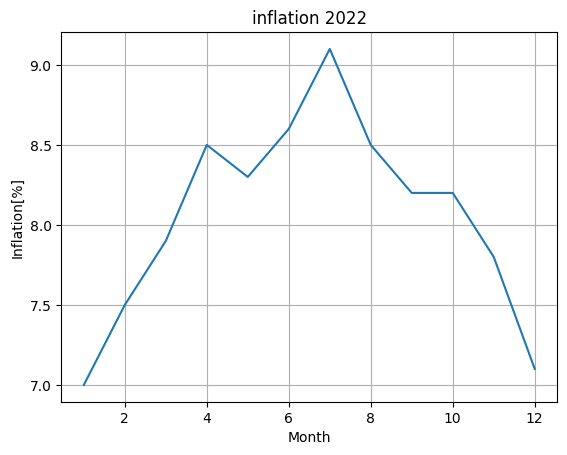

In [28]:
#inflation plot
inflation_month = [7.0, 7.5, 7.9, 8.5, 8.3, 8.6, 9.1, 8.5, 8.2, 8.2, 7.8, 7.1]
plt.plot(range(1,13),inflation_month)
plt.xlabel("Month")
plt.ylabel("Inflation[%]")
plt.title("inflation 2022")
plt.grid()
plt.show()


In [30]:
#merging three tables into one
total = pd.concat([pt_non_inflation,pt_inflation])
total

,raw,tweets,date,contains_inflation,VADER_compound,VADER_class,retweets+quotes
0,"{'lang': 'en', 'referenced_tweets': [{'type': ...",@yacob_reyes @ElleDubG @michelesalcedo you rea...,2022-01-01 00:54:21,False,0.0000,Neutral,NaN
1,"{'reply_settings': 'everyone', 'possibly_sensi...",Be sure to tune in tonight! (Champagne not pro...,2022-01-01 01:49:02,False,0.6229,Positive,NaN
2,"{'reply_settings': 'everyone', 'possibly_sensi...",RT @washingtonweek: Our New Yearâ€™s Eve show ...,2022-01-01 01:49:17,False,0.2023,Neutral,NaN
3,"{'referenced_tweets': [{'type': 'replied_to', ...",@gaygay4gaga @reedhastings @MichaelRiedelNY @J...,2022-01-01 05:29:18,False,0.8588,Positive,NaN
4,"{'id': '1477071586205347842', 'reply_settings'...",@tomscocca The best bag though. Swear by it.,2022-01-01 06:18:03,False,0.6124,Positive,NaN
...,...,...,...,...,...,...,...
207,"{'referenced_tweets': [{'type': 'replied_to', ...",@lrozen I'm not a legal expert. But I think th...,2022-12-27 09:45:19,True,-0.5265,Negative,2.0
208,"{'id': '1608096935709396993', 'reply_settings'...",RT @OrinKerr: How bad is grade inflation at Ha...,2022-12-28 19:46:01,True,0.0516,Neutral,1014.0
209,"{'lang': 'en', 'author_id': '147649517', 'cont...","Important reminder here, via ever-helpful @ela...",2022-12-30 00:41:48,True,0.1476,Neutral,42.0
210,"{'referenced_tweets': [{'type': 'replied_to', ...",@the_vello I rented a car at Detroit airport C...,2022-12-30 03:43:17,True,0.0000,Neutral,0.0


In [33]:
# Select data for a specific month
month_total_1 = total[total['date'].dt.month == 1]
month_total_2 = total[total['date'].dt.month == 2]
month_total_3 = total[total['date'].dt.month == 3]
month_total_4 = total[total['date'].dt.month == 4]
month_total_5 = total[total['date'].dt.month == 5]
month_total_6 = total[total['date'].dt.month == 6]
month_total_7 = total[total['date'].dt.month == 7]
month_total_8 = total[total['date'].dt.month == 8]
month_total_9 = total[total['date'].dt.month == 9]
month_total_10 = total[total['date'].dt.month == 10]
month_total_11 = total[total['date'].dt.month == 11]
month_total_12 = total[total['date'].dt.month == 12]

In [34]:
# mean Sentiment evaluation
mean_month_1 = month_total_1["VADER_compound"].mean()
mean_month_2 = month_total_2["VADER_compound"].mean()
mean_month_3 = month_total_3["VADER_compound"].mean()
mean_month_4 = month_total_4["VADER_compound"].mean()
mean_month_5 = month_total_5["VADER_compound"].mean()
mean_month_6 = month_total_6["VADER_compound"].mean()
mean_month_7 = month_total_7["VADER_compound"].mean()
mean_month_8 = month_total_8["VADER_compound"].mean()
mean_month_9 = month_total_9["VADER_compound"].mean()
mean_month_10 = month_total_10["VADER_compound"].mean()
mean_month_11 = month_total_11["VADER_compound"].mean()
mean_month_12 = month_total_12["VADER_compound"].mean()
months = [mean_month_1,mean_month_2,mean_month_3,mean_month_4,mean_month_5,
          mean_month_6,mean_month_7,mean_month_8,mean_month_9,mean_month_10,mean_month_11,mean_month_12]
number_of_months =range(1,13)

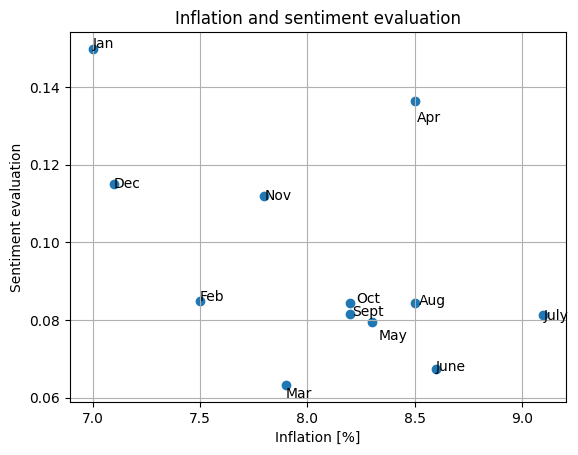

In [35]:
#plot
fig, ax = plt.subplots()
scatter = ax.scatter(inflation_month, months)
ax.grid()
ax.set_ylabel("Sentiment evaluation")
ax.set_xlabel("Inflation [%]")
ax.set_title("Inflation and sentiment evaluation")
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
ax.text(7,0.15,s='Jan', fontdict=dict(color='k',size=10))
ax.text(7.5 ,0.085,s='Feb', fontdict=dict(color='k',size=10))
ax.text(7.9,0.06,s='Mar', fontdict=dict(color='k',size=10))
ax.text(8.51,0.131,s='Apr', fontdict=dict(color='k',size=10))
ax.text(8.33,0.075,s='May', fontdict=dict(color='k',size=10))
ax.text(8.6,0.067,s='June', fontdict=dict(color='k',size=10))
ax.text(9.1,0.08,s='July', fontdict=dict(color='k',size=10))
ax.text(8.52,0.084,s='Aug', fontdict=dict(color='k',size=10))
ax.text(8.21,0.081,s='Sept', fontdict=dict(color='k',size=10))
ax.text(8.23,0.08437,s='Oct', fontdict=dict(color='k',size=10))
ax.text(7.8,0.111,s='Nov', fontdict=dict(color='k',size=10))
ax.text(7.1,0.114,s='Dec', fontdict=dict(color='k',size=10))
plt.show()

In [36]:
from scipy.stats import spearmanr
#print a correlation coefficient
cor= spearmanr(inflation_month,months)
print(cor)

SpearmanrResult(correlation=-0.5368454099542155, pvalue=0.07191028906104065)
